# Hypothesis testing

In [301]:
import pandas as pd
import numpy as np

df = pd.read_csv("telco_preprocessed.csv", index_col=0)

In this part of the report, we want to look closer at which variables impact the variable churn, as well as test different hypotheses. As we have seen in the exploratory data analysis, the dataset consists of 3 quantitative and 21 categorical variables. We will use a two-sample proportion test for the categorical variables, and a two-sample t-test of means for the quantitative.

### Creating a function for performing proportion testing
We were not able to find a pre-made function for performing two-sample proportion tests. Below, we have implemented a function calculating the z-statistic and p-value according to the following formula.

<center><img src="formula.png"></center>

* p1 and p2 is the proportions in each sample
* n1 and n2 is the number of observations in each sample
* Y1 and Y2 is the number of "yes" in each sample, for the variable of which we are looking at proportions
* p is then the pooled proportion of the two samples

In [302]:
from scipy import stats

## Function for performing a two-sample, two-sided proportion test
# df1: sample 1
# df2: sample 2
# greater: if True, performs one-sided test ("greater than"). If False, two-sided (default)

def proportion_test(df1, df2, greater=False):
    n1 = len(df1)
    n2 = len(df2)
    n = n1 + n2
    
    p1 = np.mean(df1)
    p2 = np.mean(df2)
    
    Y1 = p1*n1
    Y2 = p2*n2
    
    p = (Y1+Y2)/(n1+n2)
        
    z_statistic = (p1-p2)/(np.sqrt(p*(1-p)*(1/n1+1/n2)))
    
    p_value = stats.norm.sf(abs(z_statistic))*2
    
    if greater==True:
        p_value = stats.norm.sf(z_statistic)

    print("z-statistic: {:.4f}, p-value: {:.4f}".format(z_statistic, p_value))
#     return z_statistic, p_value

### Testing categorical variables

If we want to explore which categorical variables affect churn, we can begin by looking at the proportion of churn in each category in our dataset.

In [304]:
# df: the dataframe for which we want to calculate proportions
# cols: the categorical variables we want to calculate churn proportions for
# retruns prop_df, a dataframe containing all the proportions with respect to the 

def calc_prop(df, cols):
    c0 = []
    c1 = []
    for col in cols: 
        cat0 = df[df[col] == 0]
        cat1 = df[df[col] == 1]

        c0.append(np.mean(cat0["churn"]))
        c1.append(np.mean(cat1["churn"]))
        
    d = {'No': c0, 'Yes': c1}
    prop_df = pd.DataFrame(data=d, index=cols)
    return prop_df

In [305]:
# saving all the column names to a list, and removing the non-categorical variables
# all other columns take values 0 or 1, so we can split the data into two groups for each column
cols1 = df.columns.values.tolist()
rem = ["tenure", "monthly_charges", "total_charges", "churn"]
for el in rem: 
    cols1.remove(el)

In [306]:
proportions = calc_prop(df, cols1)
proportions.sort_values(by="Yes", inplace=True)
proportions

,No,Yes
contract_2_yr,0.340501,0.028319
contract_1_yr,0.305745,0.112695
online_security,0.313296,0.146112
tech_support,0.311862,0.151663
payment_credit_card,0.296504,0.152431
dependents,0.312791,0.154502
internet_dsl,0.305063,0.189591
payment_mailed_check,0.287424,0.191067
partner,0.329580,0.196649
online_backup,0.291721,0.215315


*Note: for "gender", "Yes" is male and "No" is female.*

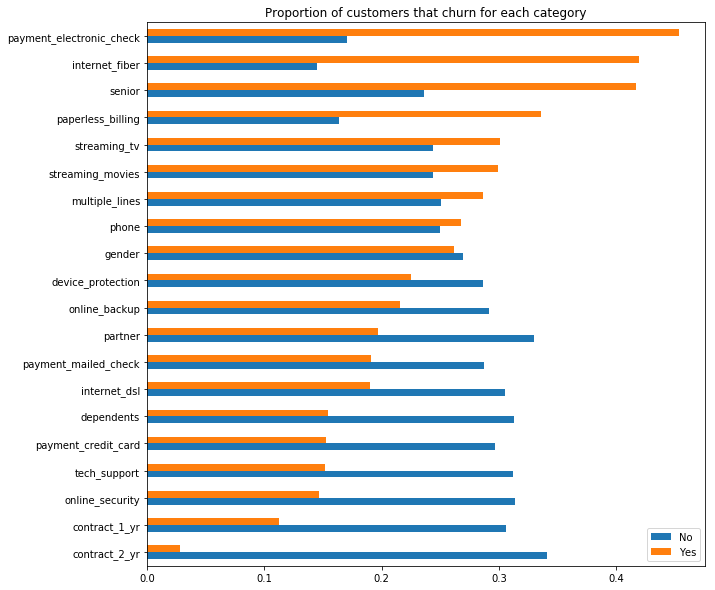

In [307]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ax = proportions.plot.barh(figsize=(10,10),
                           title="Proportion of customers that churn for each category")

We see that there are some clear differences for many of the categorical variables.
* At the very top of the plot, we find the customer category that has the *highest* proportion of churn. For customers that uses **electronic check** as their means of payment the churn rate is around 45%, compared to 17% for those who uses another payment method.
* In the other end of the plot, we find the customer category with the *lowest* proportion of churn. The proportion of customers who has a **long-term contract (2 years)** that churns is around 0.028, while the same proportion for those with other kinds of contracts are above 0.34. 
* In the middle somewhere, we see the categorical variable **gender**, where the blue bar ("No") represents females, and the orange bar ("Yes") represents males. We see that the proportions that churns for the two genders looks approximately equal.

This leads us to our first hypothesis.

**Hypothesis 1: There is a difference between the churn rate for males and females**  
Our null hypothesis is that the proportions are equal, while our alternative hypothesis is that they are different. We use the function proportion_test defined above, which returns the z-statistic and p-value of a two-sided, two-sample proportion test. We will use alpha = 0.05 as our significance level. 

In [244]:
# splitting the dataset into males and females
males = df[df["gender"] == 1]
females = df[df["gender"] == 0]
print(males.shape, females.shape)

(3555, 24) (3488, 24)


In [245]:
proportion_test(males.churn, females.churn, greater=False)

z-statistic: -0.7227, p-value: 0.4698


The p-value is 0.47, which means that we do not reject the null hypothesis. This means that we can safely say that there is no significant difference in the churn rate between men and women.

We can also define a test loop function and test whether or not the proportion of males and females that subscribe to different services are statistically different or not, i.e. if gender affects the probability that a customer is subscribing to a certain service. We will test this for a subset of the services that are included as categorical variables in our dataset.

In [246]:
# df1: sample 1
# df2: sample 2
# cols: varaibles for which we would like to perform a proportion test between the two samples
# onesided: True if one-sided test, False if two-sided test
def test_loop(df1, df2, cols, greater):
    for col in cols:
        proportion_test(df1[col], df2[col], greater=greater)

In [247]:
colz = ["streaming_movies", "tech_support", "online_backup", "device_protection"]
test_loop(males, females, colz, False)

z-statistic: -0.8801, p-value: 0.3788
z-statistic: -0.7731, p-value: 0.4395
z-statistic: -1.1559, p-value: 0.2477
z-statistic: -0.1766, p-value: 0.8598


Based on the resulting p-values, we see there is no statistically significant difference between men and women when it comes to subscribing to the services in the list above.

From the barchart of proportions discussed earlier, it looks like senior citizen are more likely to churn than non-senior citizen. In fact, the proportion of senior citizen that churn is approximately 0.42, while the proportion of non-senior citizen that churn is around 0.24. This leads us to testing our second hypothesis.

**Hypothesis 2: There is a difference between the churn rate of senior and non-senior customers**  
Again, our null hypothesis is that the two proportions are equal, and our alternative hypothesis is that they are different. We use the two-sided, two-sample proportions test again.

In [248]:
# split dataset into seniors and non-seniors 
seniors = df[df["senior"] == 1] 
non_seniors = df[df["senior"] == 0]
print(seniors.shape, non_seniors.shape)

(1142, 24) (5901, 24)


In [249]:
proportion_test(seniors.churn, non_seniors.churn, greater=False)

z-statistic: 12.6630, p-value: 0.0000


The z-statistic is large, and the p-value is very close to zero. This means that we reject our null hypothesis, and that the conclusion of our test is that the churn rate is different for senior and non-senior citizen. There could be many reasons for this, but an obvious one would be that senior customers are old and pass away more frequently than non-senior customers, which naturally leads to ending their telecom subscription.  

When testing males against females, we also tested whether or not there is a difference in their tendency to subscribe to certain services. Below, we perform the same tests for senior against non-senior citizen.

In [250]:
colz = ["streaming_movies", "tech_support", "online_backup", "device_protection"]
test_loop(seniors, non_seniors, colz, greater=False)

z-statistic: 10.0855, p-value: 0.0000
z-statistic: -5.0878, p-value: 0.0000
z-statistic: 5.5869, p-value: 0.0000
z-statistic: 4.9874, p-value: 0.0000


The results are somewhat surprising. We see that all the p-values are very close to zero, which means that there is a significant difference in the proportion of senior customers who subscribes to the services, and the proportion of non-senior customers who does the same. If we look at the z-statistics, we see that senior customers more often subscribe to movies streaming, online backup and device protection than non-senior customers.  

One explanation for this could be that senior citizen has more of their subscriptions with the same company, while younger customers tend to have subscriptions with several companies, like Netflix for streaming movies. It is also a possible explanation that seniors more often opt for add-on services that are not essential, like online backup and device protection, while younger customers are more price-sensitive and choose only the most essential services.  

The most surprising result, however, is the fact that senior customers are *less* likely to subscribe to tech support than non-senior citizen. For this, we have no good explanation.

**Hypothesis 3: Families are more loyal customers (i.e. churn less), and they are more likely to subscribe to additional services**  
To test this hypothesis, we will combine the categorical variables "partner" and "dependents" to a subset of the data which we can think of as "family". 

We first test whether or not families are more loyal customers than non-families. For this test, our null hypothesis is no difference in proportions that churn, and our alternative hypothesis is that the proportion of churn is *greater* for *non-families* than for families.

In [308]:
# splitting the dataset into families and non-families
families = df[(df["partner"]==1) & (df["dependents"]==1)]
non_families = df[(df["partner"]==0) | (df["dependents"]==0)]
print(families.shape, non_families.shape)

(1749, 24) (5294, 24)


In [311]:
proportion_test(non_families.churn, families.churn, greater=True)

z-statistic: 13.4381, p-value: 0.0000


The z-statistic is large and the p-value is very close to zero. This means that we clearly reject the null hypothesis of equal proportions and conclude that the non-families are more likely to churn. In other words, we establish that families are more loyal customers than non-families, in that they are less likely to churn.  

In [314]:
colz = ["streaming_movies", "tech_support", "online_backup", "device_protection"]
test_loop(families, non_families, colz, greater=False)

z-statistic: -0.7042, p-value: 0.4813
z-statistic: 6.2231, p-value: 0.0000
z-statistic: 3.7020, p-value: 0.0002
z-statistic: 3.9216, p-value: 0.0001


We see that for movies streaming, we do not have a significant difference between the proportions of families and non-families that subscribe, since the z-statistic is low and the p-value is 0.48. For the other variables however, all have high z-scores and p-values well below our threshold of 0.05. This means that there is a significant difference between the proportion of families who subscribe to tech support, online backup and device protection compared to other customers. One explanation for this is that families consists of more people than non-families, and hence they tend to subscribe to more services. We can also reason that families are more likely to subscribe to additional services like tech support because it allows the whole family to utilize it, and it therefore becomes relatively cheaper than for single customers.

### Testing quantitative variables

In addition to the categorical variables we have three quantitative variables in our dataset; monthly charges, total charges and tenure. We begin by taking a closer look at the correlation between them, and their correlation with the churn variable.

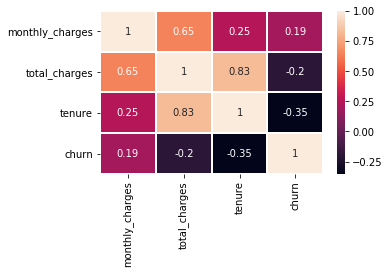

In [315]:
quant_vars = ["monthly_charges", "total_charges", "tenure", "churn"]

corr = df[quant_vars].corr()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,3))
sns.heatmap(corr, annot=True, linewidths=1, ax=ax)
plt.show()

Tenure and total_charges are naturally highly positively correlated, because total charges is the total amount the customer has paid to the company, and tenure is the number of months since he or she became a customer. Moreover, it's not surprising that monthly charges and total charges are also positively correlated.  

For the correlations with the churn variable, we see that tenure and total charges is slightly negatively correlated. The longer a customer has been associated with the company, and the higher the amount paid to the company, the less likely he or she is to churn. Monthly charges is slightly positively correlated with chrun, which means that a as the monthly charges becomes higher, the customer is slightly more likely to churn.  

That said, we have to be careful reading too much into the correlation coefficients between the respective variables. 

**Hypothesis 4: Senior customers have on average higher tenure and pay more than non-senior customers**  
Our three null hypotheses will be that there is no difference in the mean tenure, mean monthly charges and mean total charges between senior and non-senior customers. Our three alternative hypothesis will be that the mean values are *greater* for senior citizen than for other customers.  

To test these hypotheses we will use two-sample t-tests using the ttest_ind function from scipy.stats. 

In [316]:
# df1: sample 1
# df2: sample 2
# cols: varaibles for which we would like to perform a mean test between the two samples
# greater: True if one-sided test ("greater than"), False if two-sided test
def t_test_loop(df1, df2, cols, greater=False):
    for col in cols: 
        res = ttest_ind(df1[col], df2[col])
        t = res.statistic
        p = res.pvalue
        
        
        if greater==True:
            n1 = df1.shape[0]
            n2 = df2.shape[0]
            df = min(n1-1, n2-1)
            p = stats.t.sf(t, df=df)
            
        print("{} | t-statistic: {:.3f} | p-value: {:.3f}".format(col, t, p))

In [317]:
quant_vars = ["monthly_charges", "total_charges", "tenure"]
t_test_loop(seniors, non_seniors, quant_vars, greater=True)

monthly_charges | t-statistic: 18.940 | p-value: 0.000
total_charges | t-statistic: 8.690 | p-value: 0.000
tenure | t-statistic: 1.390 | p-value: 0.082


We see that the t-statistics are large and the p-values approximately zero for monthly and total charges. This means that we reject the two null hypotheses that the mean charges for seniors are equal to the mean charges for other customers. In other words, we establish that senior customers pay more on average than the rest of the customer base. One possible explanation could be that the older customers are subscribing to older plans, and that telecom services have become cheaper over time. Earlier we also established that senior customers are more likely to subscribe to additional services like device protection and online backup.

Furthermore, we see that the t-statistic for the tenure variable is fairly low, and that the p-value for this test is 0.082. This is above our threshold of 0.05, which means that we do not reject the null hypothesis and conclude that there is no difference in the mean tenure between seniors and non-seniors. This is a bit surprising, as we would assume that many senior customers have been subscribing to the company for a long time. 

The fact that there is no difference average tenure highlights the role monthly charges plays when it comes to the difference in total charges between senior and non-senior customers. Since there is no significant difference in tenure, we can attribute the higher average total charges for senior customers to the fact that their monthly charges are higher. This is also reflected by the t-statistics; for monthly charges it is even higher than for total charges, which implies that the difference in total charges originates mainly from high monthly charges.

**Hypothesis 5: Families have have on average a higher tenure and pay more than other customers**  
Our final hypothesis test will be similar to the previous, but this time for families and non-families. Because families consits of more users than a couple or a single customer, we assume that the families spend more. Our three null hypotheses are that the mean values for charges and tenure are equal for families than non-families. Consequently, our three alternative hypotheses are that the mean values are greater for families than non-families.

In [318]:
t_test_loop(families, non_families, quant_vars, greater=True)

monthly_charges | t-statistic: -6.094 | p-value: 1.000
total_charges | t-statistic: 9.704 | p-value: 0.000
tenure | t-statistic: 18.067 | p-value: 0.000


Quite surprisingly, the test for monthly charges is clearly non-significant, which means that we do not reject the null hypothesis that the means are equal. However, we see that the t-statistic is very low, which indicates that we framed our hypothesis counter-intuitive to what the data tells us.

In [298]:
print("Average monthly charges for families {:.2f} \nAverage monthly charges for non-families {:.2f}".
      format(np.mean(families.monthly_charges), np.mean(non_families.monthly_charges)))

Average monthly charges for families 60.97 
Average monthly charges for non-families 66.01


We see that the average monthly charges for non-families is actually considerable higher than for families. Our test would have been better framed the opposite way; mean monthly charges is greater for non-families than families.

In [300]:
t_test_loop(non_families, families, cols = ["monthly_charges"], greater=True)

monthly_charges | t-statistic: 6.094 | p-value: 0.000


This tells us the same - that the mean monthly charges of non-families is greater than the mean of families - but allows us to reject the null hypothesis and establish the difference in means.  

Furthermore, from the results of the two other tests we see that we can reject both null hypotheses. This means that we can establish that the mean values for total charges and tenure is significantly *greater for families* than for non-families. Considering the results we got when we tested seniors agianst non-seniors (where seniors had higher monthly and total charges, but the same tenure), this is a bit surprising. Here we see that non-families have the highest monthly charges, but because families typically have a longer tenure, their total charges is higher than for non-families. This showcases the dynamic between monthly charges, total charges and tenure - both tenure and monthly charges determines the total charges, but which variable that has the strongest effect on total charges differs between groups of customers.